In [3]:
!pip install optuna plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 23.3 MB/s eta 0:00:00


**랜덤포레스트(OPTUNA / 피처엔지니어링)**

[I 2025-09-10 01:22:42,704] A new study created in memory with name: no-name-04ff6e28-2161-48d9-8794-031326f7c669
[I 2025-09-10 01:22:47,557] Trial 0 finished with value: 0.9522238096896121 and parameters: {'n_estimators': 386, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.9858794722197485}. Best is trial 0 with value: 0.9522238096896121.
[I 2025-09-10 01:22:51,837] Trial 1 finished with value: 0.9330777007437648 and parameters: {'n_estimators': 434, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.7311553601962175}. Best is trial 0 with value: 0.9522238096896121.
[I 2025-09-10 01:22:54,620] Trial 2 finished with value: 0.49178784761659877 and parameters: {'n_estimators': 374, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 17, 'max_features': 0.8019497356227582}. Best is trial 0 with value: 0.9522238096896121.
[I 2025-09-10 01:23:01,108] Trial 3 finished with value: 0.7288457918213808 and parameters: {'n

Best Params: {'n_estimators': 426, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.9454990433027031}
Best R2: 0.9704711469915562
Test R2: 0.9973, RMSE: 24.31, MAE: 16.99


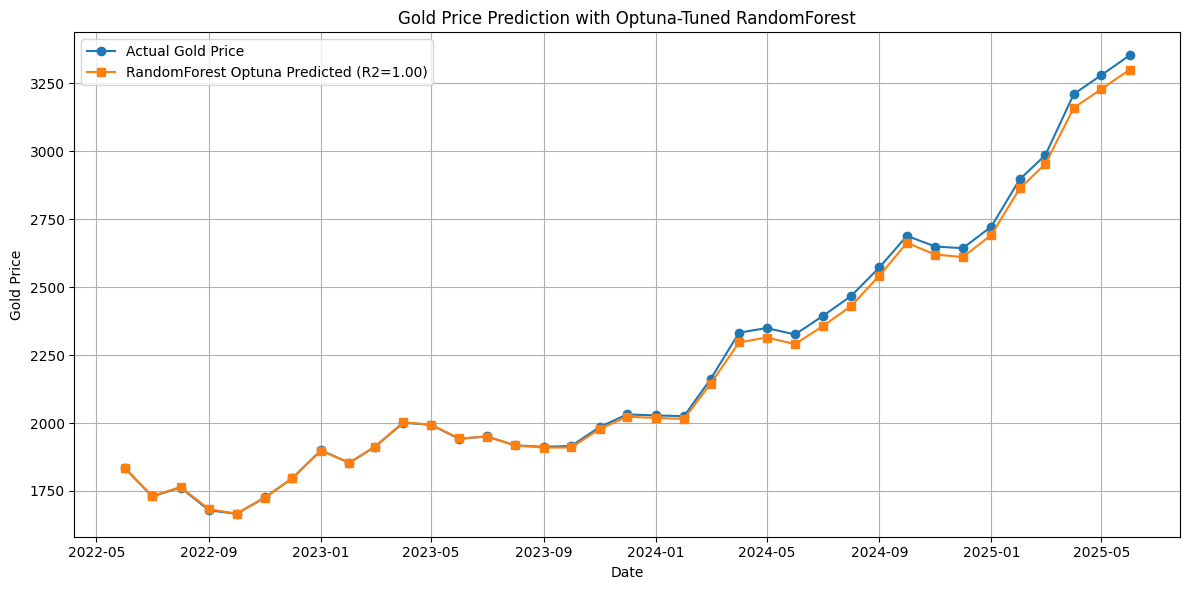

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from sklearn.ensemble import RandomForestRegressor # RandomForestRegressor import

# ==============================
# 1. 데이터 준비
# ==============================
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)
# Feature Engineering
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['gold_lag1'] = df['Gold_Price'].shift(1)
df['gold_lag3'] = df['Gold_Price'].shift(3)
df['gold_roll3'] = df['Gold_Price'].rolling(3).mean()
df['gold_return'] = df['Gold_Price'].pct_change()
df['m2_growth'] = df['US_M2_Money_Supply'].pct_change()
df['cpi_inflation'] = df['US_CPI'].pct_change()
df['gold_log'] = np.log(df['Gold_Price'])
df['gold_log_diff1'] = df['gold_log'].diff(1)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df = df.dropna().reset_index(drop=True)
# Features & Target
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date", "gold_log", "gold_log_diff1"])
y = df["gold_log_diff1"]

# ==============================
# 2. Optuna Objective 정의 (RandomForest용)
# ==============================
def objective(trial):
    # RandomForest에 맞는 하이퍼파라미터 샘플링
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_float("max_features", 0.6, 1.0),
        "random_state": 42
    }

    # 파이프라인 (모델 부분만 변경)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(**params))
    ])

    # TimeSeriesSplit 검증
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        scores.append(r2_score(y_val, y_pred))

    return np.mean(scores)

# ==============================
# 3. Optuna 실행
# ==============================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50) # n_trials는 필요에 따라 조정
print("Best Params:", study.best_params)
print("Best R2:", study.best_value)

# ==============================
# 4. 최적 하이퍼파라미터로 최종 학습
# ==============================
best_params = study.best_params
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(**best_params))
])

# 데이터 분할 (학습: 80%, 테스트: 20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

final_model.fit(X_train, y_train)

# ==============================
# 5. 테스트셋 예측 및 가격 복원
# ==============================
y_pred_diff = final_model.predict(X_test)
# 로그 차분 → 가격 복원
last_log_price = df.loc[y_test.index[0] - 1, "gold_log"]
y_pred_log = np.cumsum(y_pred_diff) + last_log_price
y_pred_price = np.exp(y_pred_log)
y_test_price = df.loc[y_test.index, "Gold_Price"]
# 성능 평가
r2 = r2_score(y_test_price, y_pred_price)
rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
mae = mean_absolute_error(y_test_price, y_pred_price)
print(f"Test R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ==============================
# 6. 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test_price.values, label="Actual Gold Price", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"RandomForest Optuna Predicted (R2={r2:.2f})", marker='s')
plt.title("Gold Price Prediction with Optuna-Tuned RandomForest")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**피처 엔지니어링 X / Optuna O**



[I 2025-09-10 01:29:31,157] A new study created in memory with name: no-name-6a743608-3e7e-4b6a-ad45-5050a9163b59
[I 2025-09-10 01:29:38,495] Trial 0 finished with value: -10.288738244284477 and parameters: {'n_estimators': 647, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 10}. Best is trial 0 with value: -10.288738244284477.
[I 2025-09-10 01:29:40,625] Trial 1 finished with value: -7.394312551068007 and parameters: {'n_estimators': 246, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 1 with value: -7.394312551068007.
[I 2025-09-10 01:29:42,584] Trial 2 finished with value: -8.12120181632205 and parameters: {'n_estimators': 238, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 1 with value: -7.394312551068007.
[I 2025-09-10 01:29:47,588] Trial 3 finished with value: -9.323753251932803 and parameters: {'n_estimators': 407, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 20}. Best is trial 1 with va

Best Params: {'n_estimators': 421, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1}
Scenario 1 - Test R2: -1.2676, MAE: 536.48


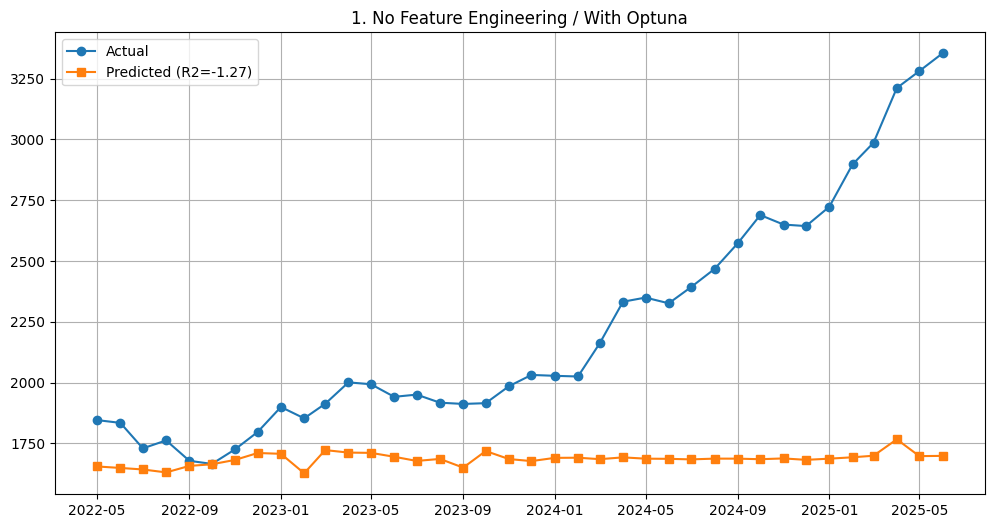

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from sklearn.ensemble import RandomForestRegressor

# --- 데이터 준비 ---
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date"])
y = df["Gold_Price"]
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# --- Optuna Objective 정의 ---
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "random_state": 42
    }
    pipeline = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor(**params))])
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        pipeline.fit(X_train_cv, y_train_cv)
        scores.append(r2_score(y_val_cv, pipeline.predict(X_val_cv)))
    return np.mean(scores)

# --- Optuna 실행 ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print("Best Params:", study.best_params)

# --- 최종 학습 및 예측 ---
best_params = study.best_params
final_model = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor(**best_params))])
final_model.fit(X_train, y_train)
y_pred_price = final_model.predict(X_test)

# --- 성능 평가 및 시각화 ---
r2 = r2_score(y_test, y_pred_price)
mae = mean_absolute_error(y_test, y_pred_price)
print(f"Scenario 1 - Test R2: {r2:.4f}, MAE: {mae:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test, label="Actual", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"Predicted (R2={r2:.2f})", marker='s')
plt.title("1. No Feature Engineering / With Optuna")
plt.legend()
plt.grid(True)
plt.show()

**피처 엔지니어링 X / Optuna X (기본 모델)**

Scenario 2 - Test R2: -1.2812, MAE: 541.66


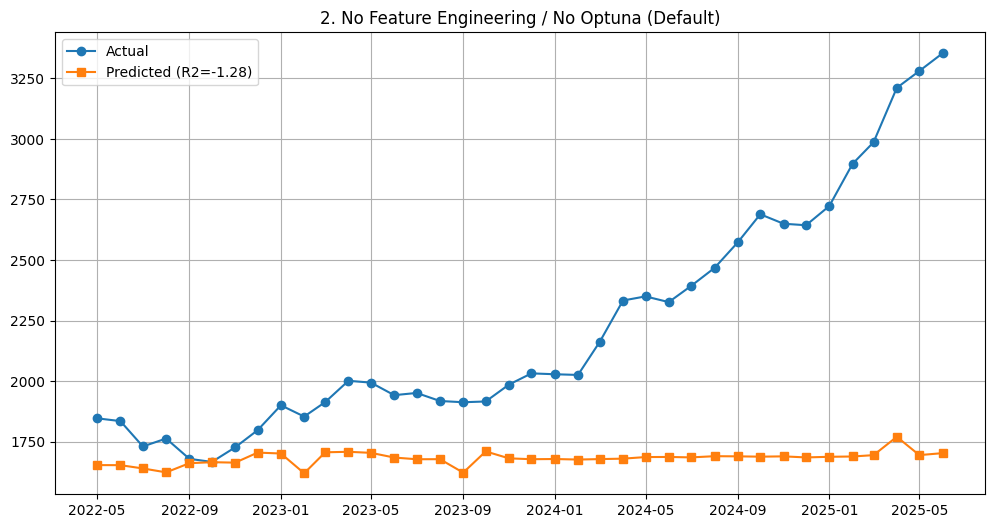

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# --- 데이터 준비 ---
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date"])
y = df["Gold_Price"]
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# --- 모델 생성 및 학습 ---
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42)) # 기본 하이퍼파라미터
])
pipeline.fit(X_train, y_train)

# --- 예측 및 성능 평가 ---
y_pred_price = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred_price)
mae = mean_absolute_error(y_test, y_pred_price)
print(f"Scenario 2 - Test R2: {r2:.4f}, MAE: {mae:.2f}")

# --- 시각화 ---
plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test, label="Actual", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"Predicted (R2={r2:.2f})", marker='s')
plt.title("2. No Feature Engineering / No Optuna (Default)")
plt.legend()
plt.grid(True)
plt.show()

**피처 엔지니어링 O / Optuna X (기본 모델)**

Scenario 3 - Test R2: -4.3690, MAE: 882.42


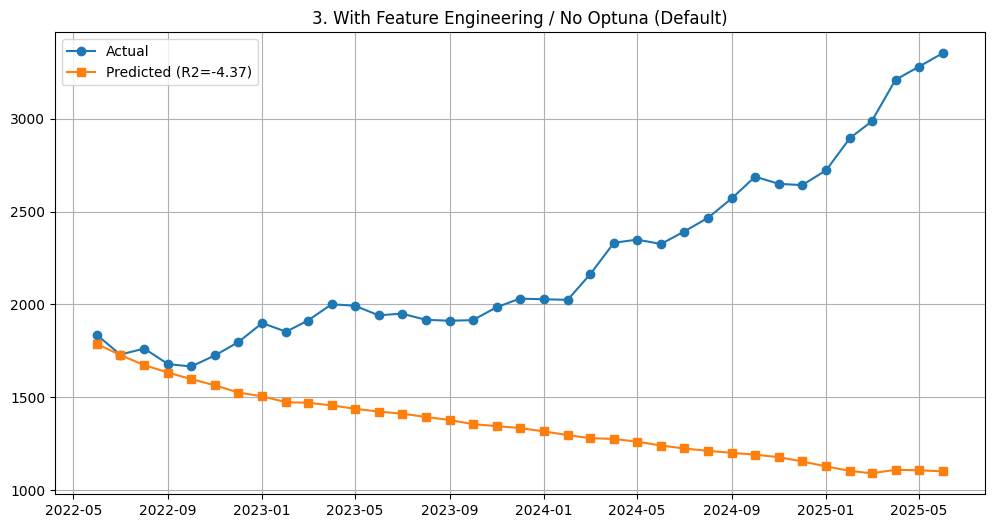

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# --- 데이터 준비 및 피처 엔지니어링 ---
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)
df['gold_lag1'] = df['Gold_Price'].shift(1)
df['gold_lag3'] = df['Gold_Price'].shift(3)
df['gold_roll3'] = df['Gold_Price'].rolling(3).mean()
df['gold_log'] = np.log(df['Gold_Price'])
df['gold_log_diff1'] = df['gold_log'].diff(1)
df = df.dropna().reset_index(drop=True)
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date", "gold_log", "gold_log_diff1"])
y = df["gold_log_diff1"]
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# --- 모델 생성 및 학습 ---
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42)) # 기본 하이퍼파라미터
])
pipeline.fit(X_train, y_train)

# --- 예측 및 가격 복원 ---
y_pred_diff = pipeline.predict(X_test)
last_log_price = df.loc[y_test.index[0] - 1, "gold_log"]
y_pred_log = np.cumsum(y_pred_diff) + last_log_price
y_pred_price = np.exp(y_pred_log)
y_test_price = df.loc[y_test.index, "Gold_Price"]

# --- 성능 평가 및 시각화 ---
r2 = r2_score(y_test_price, y_pred_price)
mae = mean_absolute_error(y_test_price, y_pred_price)
print(f"Scenario 3 - Test R2: {r2:.4f}, MAE: {mae:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test_price, label="Actual", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"Predicted (R2={r2:.2f})", marker='s')
plt.title("3. With Feature Engineering / No Optuna (Default)")
plt.legend()
plt.grid(True)
plt.show()

**최종 예측 모델 코드 (피처O + OptunaO + y값 shift)**

[I 2025-09-10 01:35:21,055] A new study created in memory with name: no-name-8dd0e6bc-c00d-4897-aaa7-da61b58e7db5
[I 2025-09-10 01:35:33,191] Trial 0 finished with value: -1.8173383112121209 and parameters: {'n_estimators': 782, 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 1}. Best is trial 0 with value: -1.8173383112121209.
[I 2025-09-10 01:35:43,193] Trial 1 finished with value: -2.0540441803173315 and parameters: {'n_estimators': 950, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: -1.8173383112121209.
[I 2025-09-10 01:35:51,077] Trial 2 finished with value: -2.047123841155609 and parameters: {'n_estimators': 782, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 0 with value: -1.8173383112121209.
[I 2025-09-10 01:35:55,327] Trial 3 finished with value: -1.8692350112043272 and parameters: {'n_estimators': 459, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 0 w

Best Params: {'n_estimators': 435, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 10}
Test R2: -0.7034, MAE: 428.99


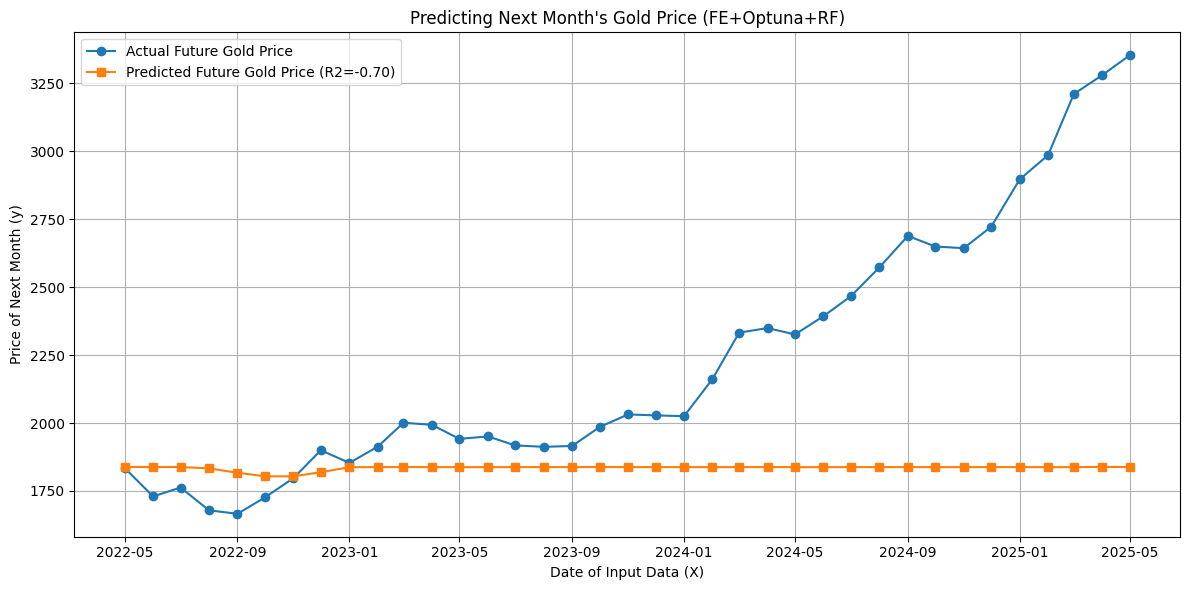

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from sklearn.ensemble import RandomForestRegressor

# ==============================
# 1. 데이터 준비 및 피처 엔지니어링
# ==============================
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

# Feature Engineering
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['gold_lag1'] = df['Gold_Price'].shift(1)
df['gold_lag3'] = df['Gold_Price'].shift(3)
df['gold_roll3'] = df['Gold_Price'].rolling(3).mean()
df['gold_log'] = np.log(df['Gold_Price'])

# ★★ 중요: y (타겟)를 다음 달 Gold_Price로 설정 ★★
df['y'] = df['Gold_Price'].shift(-1)

# 결측치 제거
df = df.dropna().reset_index(drop=True)

# Features & Target 정의
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date", "gold_log", "y"])
y = df["y"]

# ==============================
# 2. Optuna Objective 정의
# ==============================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "random_state": 42
    }
    pipeline = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor(**params))])
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(X_train_cv, y_train_cv)
        scores.append(r2_score(y_val_cv, pipeline.predict(X_val_cv)))
    return np.mean(scores)

# ==============================
# 3. Optuna 실행
# ==============================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best Params:", study.best_params)

# ==============================
# 4. 최적 하이퍼파라미터로 최종 학습
# ==============================
best_params = study.best_params
final_model = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor(**best_params))])
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
final_model.fit(X_train, y_train)

# ==============================
# 5. 테스트셋 예측 및 성능 평가
# ==============================
y_pred_price = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred_price)
mae = mean_absolute_error(y_test, y_pred_price)
print(f"Test R2: {r2:.4f}, MAE: {mae:.2f}")

# ==============================
# 6. 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test, label="Actual Future Gold Price", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"Predicted Future Gold Price (R2={r2:.2f})", marker='s')
plt.title("Predicting Next Month's Gold Price (FE+Optuna+RF)")
plt.xlabel("Date of Input Data (X)")
plt.ylabel("Price of Next Month (y)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

***변동률 예측 모델 (로그 차분 예측) 코드***

[I 2025-09-10 01:43:08,921] A new study created in memory with name: no-name-ede5d1ce-484a-4330-9956-68e1c4f5fb08
[I 2025-09-10 01:43:19,098] Trial 0 finished with value: -0.3824117737045593 and parameters: {'n_estimators': 680, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.3824117737045593.
[I 2025-09-10 01:43:21,625] Trial 1 finished with value: -0.21675859055540295 and parameters: {'n_estimators': 308, 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 12}. Best is trial 1 with value: -0.21675859055540295.
[I 2025-09-10 01:43:29,361] Trial 2 finished with value: -0.22109504881930087 and parameters: {'n_estimators': 857, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 15}. Best is trial 1 with value: -0.21675859055540295.
[I 2025-09-10 01:43:35,626] Trial 3 finished with value: -0.22188088699052244 and parameters: {'n_estimators': 751, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 15}. Best is 

Best Params: {'n_estimators': 293, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 17}
Test R2 (on restored price): 0.5227, MAE: 271.92


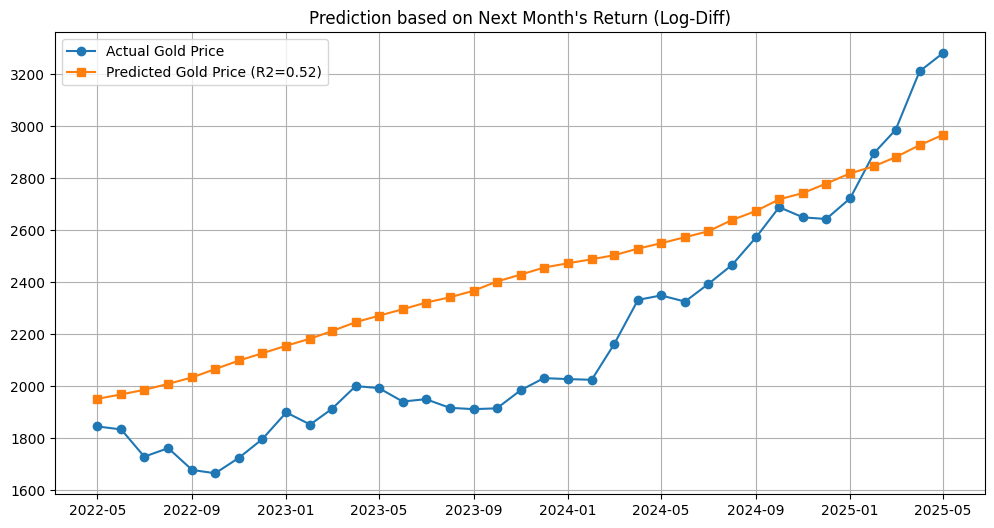

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from sklearn.ensemble import RandomForestRegressor

# ==============================
# 1. 데이터 준비 및 피처 엔지니어링
# ==============================
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)
# Feature Engineering
df['gold_lag1'] = df['Gold_Price'].shift(1)
df['gold_lag3'] = df['Gold_Price'].shift(3)
df['gold_roll3'] = df['Gold_Price'].rolling(3).mean()
df['gold_log'] = np.log(df['Gold_Price'])
# ★★ 목표 변경: 다음 달의 가격 대신, 다음 달의 '변동률'(로그 차분값)을 예측 ★★
df['y_log_diff'] = df['gold_log'].diff(1).shift(-1)
df = df.dropna().reset_index(drop=True)
# Features & Target 정의
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date", "gold_log", "y_log_diff"])
y = df["y_log_diff"]

# ==============================
# 2. Optuna Objective 정의 (이전과 동일)
# ==============================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "random_state": 42
    }
    pipeline = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor(**params))])
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(X_train_cv, y_train_cv)
        scores.append(r2_score(y_val_cv, pipeline.predict(X_val_cv)))
    return np.mean(scores)

# ==============================
# 3. Optuna 실행 (이전과 동일)
# ==============================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best Params:", study.best_params)

# ==============================
# 4. 최적 하이퍼파라미터로 최종 학습
# ==============================
best_params = study.best_params
final_model = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor(**best_params))])
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
final_model.fit(X_train, y_train)

# ==============================
# 5. 예측 및 가격 복원
# ==============================
y_pred_diff = final_model.predict(X_test)
# 테스트 시작 직전의 마지막 로그 가격을 기준점으로 사용
last_log_price = df.loc[y_test.index[0] - 1, "gold_log"]
# 예측된 변동률을 누적 합산하여 로그 가격으로 복원
y_pred_log = np.cumsum(y_pred_diff) + last_log_price
# 로그 가격을 지수 변환하여 최종 가격으로 복원
y_pred_price = np.exp(y_pred_log)
# 비교를 위한 실제 가격
y_test_price = df.loc[y_test.index, "Gold_Price"]

# ==============================
# 6. 성능 평가 및 시각화 (복원된 가격 기준)
# ==============================
r2 = r2_score(y_test_price, y_pred_price)
mae = mean_absolute_error(y_test_price, y_pred_price)
print(f"Test R2 (on restored price): {r2:.4f}, MAE: {mae:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test_price, label="Actual Gold Price", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"Predicted Gold Price (R2={r2:.2f})", marker='s')
plt.title("Prediction based on Next Month's Return (Log-Diff)")
plt.legend()
plt.grid(True)
plt.show()